In [1]:
import os
from osgeo import gdal, ogr
import geopandas as gpd
import pandas as pd
import numpy as np
files = os.listdir('shapes')

pd_shapes = {}
os_shapes = {}

for file in files:
    newfile = gpd.read_file(f'data/{file}')
    pd_shapes[str(file).replace('.shp', '')] = newfile

for file in files:
    newfile = ogr.Open(f'data/{file}')
    os_shapes[str(file).replace('.shp', '')] = newfile

os_shapes.keys()

ModuleNotFoundError: No module named 'osgeo'

In [133]:
# TownBoundary rasterization

raster_file = 'rasters/TownBoundary.tif'
layer = os_shapes['TownBoundary'].GetLayer()

# Get the extent of the vector (bounding box)
x_min, x_max, y_min, y_max = layer.GetExtent()

# Define the pixel size based on the layer's CRS units
pixel_size = 50  # Adjust to a suitable size based on your data's CRS
town_x_res = int((x_max - x_min) / pixel_size)
town_y_res = int((y_max - y_min) / pixel_size)

# Create the output raster with the same CRS as the vector layer
target_ds = gdal.GetDriverByName('GTiff').Create(raster_file, town_x_res, town_y_res, 1, gdal.GDT_Byte)

# Set the transformation (georeferencing) based on the extent of the vector data
target_ds.SetGeoTransform((x_min, pixel_size, 0, y_max, 0, -pixel_size))

# Set the same projection as the vector layer
spatial_ref = layer.GetSpatialRef()
target_ds.SetProjection(spatial_ref.ExportToWkt())  # Use the vector's CRS

# Get raster band
band = target_ds.GetRasterBand(1)
band.Fill(0)  # Initialize raster with zeros (optional)
band.SetNoDataValue(0)  # Set no-data value

# Rasterize the entire layer (burn values of 1 for the boundary)
gdal.RasterizeLayer(target_ds, [1], layer, burn_values=[1])

# Close datasets
target_ds = None
layer = None

print(f"TownBoundary rasterization complete. Output saved at {raster_file}.")

TownBoundary rasterization complete. Output saved at rasters/TownBoundary.tif.


In [134]:
# Communityfeatures Euclidean distance

from scipy.ndimage import distance_transform_edt

raster_file = 'rasters/Communityfeatures.tif'
layer = os_shapes['Communityfeatures'].GetLayer()

# Get the extent of the vector (bounding box)
x_min, x_max, y_min, y_max = layer.GetExtent()

# Define the resolution of the raster (pixels in x and y directions)
pixel_size = 50  # Adjusted to 10
# x_res = int((x_max - x_min) / pixel_size)
# y_res = int((y_max - y_min) / pixel_size)


x_res = town_x_res
y_res = town_y_res

# Create the output raster
target_ds = gdal.GetDriverByName('GTiff').Create(raster_file, x_res, y_res, 1, gdal.GDT_Float32)

# Set the transformation (georeferencing)
target_ds.SetGeoTransform((x_min, pixel_size, 0, y_max, 0, -pixel_size))

# Get raster band
band = target_ds.GetRasterBand(1)
band.Fill(0)  # Initialize raster with zeros
band.SetNoDataValue(0)  # Set no-data value

# Initialize an array to store the weighted distance results
distance_raster = np.zeros((y_res, x_res), dtype=np.float32)

# Loop through each feature (point) in the layer using GetNextFeature
feature = layer.GetNextFeature()  # Get the first feature
while feature is not None:
    geom = feature.GetGeometryRef()
    weight = feature.GetField('weight')  # Replace 'weight' with the actual column name

    # Create a new in-memory layer with just this one feature
    driver = ogr.GetDriverByName('MEMORY')
    temp_ds = driver.CreateDataSource('temp')
    temp_layer = temp_ds.CreateLayer('tempLayer', geom_type=ogr.wkbPoint)
    temp_layer.CreateFeature(feature.Clone())  # Clone the current feature into the temp layer

    # Rasterize the single feature to create a temporary mask (value=1 where the point is)
    temp_raster = gdal.GetDriverByName('MEM').Create('', x_res, y_res, 1, gdal.GDT_Byte)
    temp_raster.SetGeoTransform((x_min, pixel_size, 0, y_max, 0, -pixel_size))
    temp_band = temp_raster.GetRasterBand(1)
    temp_band.Fill(0)  # Initialize with zeros
    gdal.RasterizeLayer(temp_raster, [1], temp_layer, burn_values=[1], options=['ALL_TOUCHED=TRUE'])

    # Read the temporary rasterized point data into an array
    point_mask = temp_band.ReadAsArray()

    # Compute Euclidean distance from the point
    distance = distance_transform_edt(point_mask == 0)

    # Apply the weight reduction formula (e.g., weight / distance)
    weighted_distance = np.where(distance > 0, weight / distance, weight)

    # Combine the weighted distance for this point into the main raster
    distance_raster = np.maximum(distance_raster, weighted_distance)  # Take the max of weighted distances

    # Print the feature ID to verify it's iterating correctly
    print(f"Processed feature with ID: {feature.GetFID()} and weight: {weight}")

    # Get the next feature
    feature = layer.GetNextFeature()

# Write the combined weighted distance raster to the output
band.WriteArray(distance_raster)

# Close datasets
target_ds = None
layer = None

print(f"Weighted Euclidean distance rasterization complete. Output saved at {raster_file}.")

Processed feature with ID: 0 and weight: 5
Processed feature with ID: 1 and weight: 9
Processed feature with ID: 2 and weight: 3
Processed feature with ID: 3 and weight: 4
Processed feature with ID: 4 and weight: 1
Processed feature with ID: 5 and weight: 2
Processed feature with ID: 6 and weight: 7
Processed feature with ID: 7 and weight: 6
Weighted Euclidean distance rasterization complete. Output saved at rasters/Communityfeatures.tif.


C:\Users\omarm\AppData\Local\Temp\ipykernel_14940\2917433721.py:60: RuntimeWarning: divide by zero encountered in divide
  weighted_distance = np.where(distance > 0, weight / distance, weight)


In [135]:
# BEAUTIFUL PLOT
import matplotlib.pyplot as plt

# # Plot the polygons first

# ax = shapes['TownBoundary'].plot(color='lightblue', edgecolor='black')

# # # Plot the points on top of the polygons
# shapes['TownBoundary'].plot(ax=ax, marker='o', color='red', markersize=5)

# # Customize the plot (optional)
# plt.title('Polygons with Points Overlay')
# plt.xlabel('Longitude')
# plt.ylabel('Latitude')

# # Show the plot
# plt.show()

Text(0.5, 1.0, 'Raster Plot')

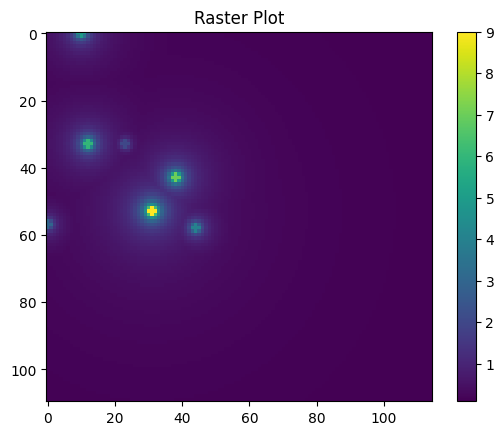

In [136]:
# plot the raster
import matplotlib.pyplot as plt

# Open the raster file
raster = gdal.Open('rasters/Communityfeatures.tif')

# Get the raster data
data = raster.ReadAsArray()

# Plot the raster
plt.imshow(data)
plt.colorbar()
plt.title('Raster Plot')

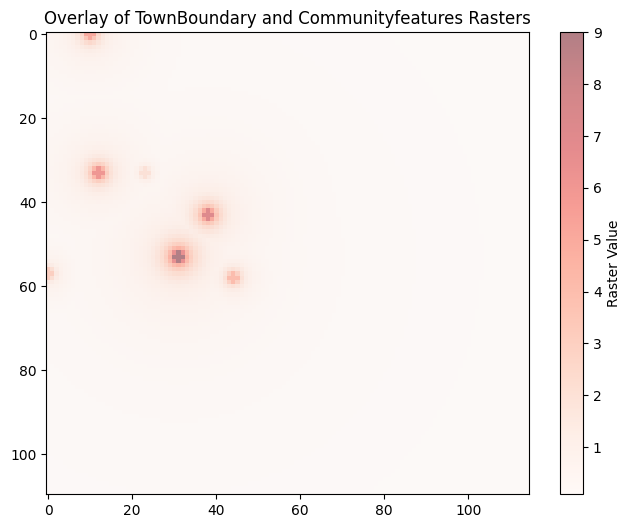

In [137]:
# Read the raster data

town_raster = gdal.Open('rasters/TownBoundary.tif')
community_raster = gdal.Open('rasters/Communityfeatures.tif')

town_data = town_raster.GetRasterBand(1).ReadAsArray()
community_data = community_raster.GetRasterBand(1).ReadAsArray()

# Plot the rasters
plt.figure(figsize=(8, 6))


# Plot the TownBoundary raster
plt.imshow(town_data, cmap='Blues', alpha=0.5)  # Adjust alpha for transparency

# Plot the Communityfeatures raster on top
plt.imshow(community_data, cmap='Reds', alpha=0.5)  # Adjust alpha for transparency

# Add a colorbar and title
plt.colorbar(label='Raster Value')
plt.title('Overlay of TownBoundary and Communityfeatures Rasters')

# Show the plot
plt.show()